In [2]:
# %matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import deepdish as dd
from pathlib import Path

# Load the data

In [3]:
data_root = Path("/mnt/c/Users/Cristina/Documents/SS19/lsmda/Portugues/")
traces = dd.io.load(str(data_root / "traces_better_deconvolved.h5"))

In [4]:
stim_log = dd.io.load(str(data_root / "stimulus_log.h5"))
behavior_log = dd.io.load(str(data_root / "behavior_log.h5"))

In [5]:
fps = 1.5
n_frames_trial = 270
t_imaging = np.arange(traces.shape[1])/fps

In [6]:
dt_imaging = 1/fps

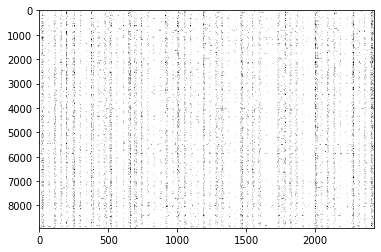

In [7]:
plt.figure()
plt.imshow(traces, aspect="auto", vmax=0.5, vmin=0, cmap="gray_r")

## Plot some stimulus parameters

Text(0.5, 0, 'time [s]')

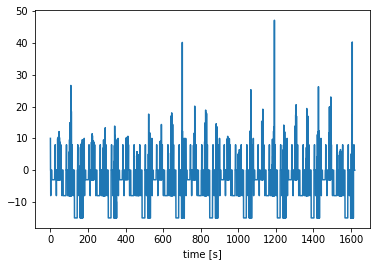

In [8]:
plt.figure()
plt.plot(stim_log.t, stim_log.gain_lag_cl1D_vel)
plt.xlabel("time [s]")

# Resample the stimulation and behavioral data in imaging time bins

In [9]:
from scipy import signal
from scipy.interpolate import interp1d

First, we resample the stimulation data so that it is equaly spaced in time, at 200 times the imaging frame rate

In [10]:
int_fact = 200
t_imaging_int = np.arange(traces.shape[1]*int_fact)*dt_imaging/int_fact

vel_int = interp1d(stim_log.t, stim_log["gain_lag_cl1D_vel"], bounds_error=False, fill_value=0)(t_imaging_int)

velocity = signal.decimate(vel_int, int_fact, ftype="fir")

The motor regressor we sould like to have will be a general measure of the fish swimming power. Such regressor can be based on the standard deviation (SD) of the tail angle during the experiment. 

Calculate vigor, a proxy for fish behavior

In [11]:
dt_beh = np.mean(np.diff(behavior_log.t[100:200]))
vig_win = 2/1.5
n_vig = int(vig_win/dt_beh)
vigor = interp1d(behavior_log.t, behavior_log.tail_sum.rolling(n_vig,  min_periods=2).std(),
                 fill_value=0.0, bounds_error=False)(t_imaging)

You can plot and examine other columns in the behavior_log, it contains full data about tail curvature.

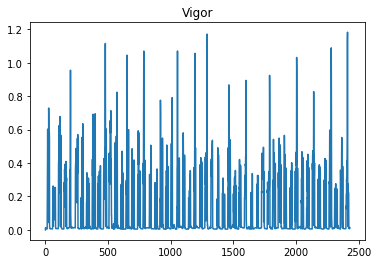

In [17]:
plt.plot(vigor)
plt.title('Vigor')
plt.show()

# Perform regression

Split the velocity into forward (<0) and backward (>0) components, and put this together with vigor in a n_timepoints x 3 matrix

In [26]:
forward = np.maximum(velocity,0)
backward = -1*np.minimum(velocity,0)
print(velocity.shape, forward.shape)
regressor = np.array([forward,backward,vigor])
print(regressor.shape)

(2430,) (2430,)
(3, 2430)


Normalize the regressors, so that each has magnitude 1 (np.linalg.norm), as well as the traces

In [32]:
regressor_normalized = regressor/np.linalg.norm(regressor)
traces_normalized = traces/np.linalg.norm(traces)

Regression analysis will then just be matrix multiplication, use the @ operator

In [36]:
regression = regressor_normalized @ traces_normalized.T
print(regression.shape)
print(regressor_normalized.shape)

(3, 8917)
(3, 2430)


In [35]:
traces_normalized.shape

(8917, 2430)

Find the traces that are correlated best with each of the regressors, and plot them. You should get something like this:
    
![](best_traces_regression.png)

Use the coordinates data to scatter plot the regression coefficients in brain coordinates.

If you want, try the plotly or ipyvolume libraries to have an interactive 3D scatterplot!

# Decode the velcity from the traces

Split the velocity and the traces into a traning and test set. Choose carefully so that most conditions are well represented

In [ ]:
traces_test = 
traces_train = 

vel_test = 
vel_train = 

Use methods from scikit-learn, starting with sklearn.linear_model.LinearRegression (or write your own linear regression!), use the fit and predict methods to decode velocity

You should get something like 

![](decoding.png)

Extra credit 
* try to determine how many cells you need to decode the velocity. Which cells are the most important ones, if there are such?
* do nonlinear decoding methods (e.g. neural networks, also available with the same interface in scikit-learn) improve the decoding?
* try to decode behavior